<center><h1>Py-Galaxies examples</h1></center>

# SUB-HALO Stars

## Import modules

In [1]:
from PyGalaxies import Parameters, Monitor, HDF_graph_properties, Halos
import time
import numpy as np


model_param_filepath='Input_Params/input_params.yml'
debug_flag = False
verbosity = 1 
time_code = True

## Get model params and print

In [2]:
model_params = Parameters.ModelParams(model_param_filepath,verbosity,debug_flag)
model_params.output_params() 

input_files         : {'graph_file': '../Input Data/mega_graph_mini_09-11.hdf5'}
output_files        : {'halo_file': '../Output Data/SMT13HaloOutput.hdf5', 'galaxy_file': '../Output Data/SMT13GalaxyOutput.hdf5'}
cosmology           : {'omega_m': {'Description': 'Matter density parameter', 'Value': 0.3, 'Units': 'None'}, 'f_baryon': {'Description': 'Baryon fraction', 'Value': 0.155, 'Units': 'None'}}
model_switches      : {'HOD': {'Description': 'Halo occupation description for stars (as primitive test)', 'Value': True}, 'sub_halo': {'Description': 'For each graph, load in Sub-halo data?', 'Value': True}}
performance         : {'io_nRec': {'Description': 'Size of HDF5 io buffer (number of records)', 'Value': 1000}}
Monitoring          : {'Timing': {'Description': 'Whether or not to time parts of code and save output', 'Value': True, 'graph_save_path': 'Graph_Outputs/Timing/', 'timing_data_save_path': 'Monitoring Data/'}}


## Run main routine

In [3]:
# Open the input HDF5 file containing graph groups and create an output file.
HDF_properties = HDF_graph_properties.HDFProperties(model_params)

start_time = time.time()

amount_of_funcs = 9

time_monitor = Monitor.Monitor(HDF_properties.no_of_graphs, 9)

cum_halo_list= []
cum_sub_halo_list = []

for graph_ID in range(0,HDF_properties.no_of_graphs):

    if verbosity >= 2: print('Processing graph',graph_ID)
    

    graph_properties = HDF_graph_properties.GraphProperties(graph_ID,
                                       HDF_properties.graph_input_file,
                                       model_params,
                                       HDF_properties.part_mass)

    
    array_of_halo_properties = np.empty(len(graph_properties.graph_halo_ids),
                                        dtype = object)
    
    if type(graph_properties.n_subhalos) == int:
        # Fill timing array with np.nan to show skipped calcs.
        time_monitor.time_storage_array[graph_ID, :, :] = np.nan
        time_monitor.memory_storage_array[graph_ID, :, :] = np.nan
        cum_halo_list.append(HDF_properties.n_halo)
        cum_sub_halo_list.append(HDF_properties.n_subhalo)
        continue

    
    # Activating timing function for this graph.
    time_monitor.graph_timer_setup(graph_properties.n_halos_in_graph)
    
    for snap_ID in graph_properties.generation_id:
        

        if graph_properties.generation_start_index[snap_ID] == 2**30:
            continue
    
        
        this_generation_halo = graph_properties.graph_halo_ids[
                               graph_properties.generation_start_index[snap_ID]:
                               graph_properties.generation_start_index[snap_ID] + 
                               graph_properties.generation_length[snap_ID]]
        
        
        
        for halo_ID in this_generation_halo:
            
            time_monitor.start_timer()
            
            halo = Halos.HaloProperties(str(graph_ID), snap_ID, halo_ID,
                                  graph_properties, HDF_properties.part_mass,
                                  HDF_properties.dtype_subhalo_stores)
            
            # Store the time at which this function has been completed
            time_monitor.store_func_time(1, halo_ID)
            
            
            
            halo.halo_descendent_props()
            time_monitor.store_func_time(2, halo_ID)
            
        
            halo.calc_halo_DM_descend(HDF_properties.part_mass)
            time_monitor.store_func_time(3, halo_ID)
                
            
            halo.calc_halo_attrs_descend(HDF_properties.part_mass, array_of_halo_properties,
                                         HDF_properties.halo_descend_attrs)
            time_monitor.store_func_time(4, halo_ID)
            
            halo.set_baryon_fraction(array_of_halo_properties, model_params.f_baryon)
            time_monitor.store_func_time(5, halo_ID)
            
            halo.collect_galaxy_prog_info(graph_properties, HDF_properties, array_of_halo_properties)
            time_monitor.store_func_time(6, halo_ID)
            
            halo.add_baryon_mass()
            time_monitor.store_func_time(7, halo_ID)
            
            halo.add_stellar_mass()
            time_monitor.store_func_time(8, halo_ID)
            
            halo.calculate_infall(model_params.f_baryon)
            time_monitor.store_func_time(9, halo_ID)
            
        
            halo.done=True
            
            array_of_halo_properties[halo_ID] = halo

            HDF_properties.n_halo +=1 
            
            
            
            
    cum_halo_list.append(HDF_properties.n_halo)   
    cum_sub_halo_list.append(HDF_properties.n_subhalo)
    time_monitor.store_average_graph_times(graph_ID)
            
            

    # Save output
    HDF_properties.output_halos(array_of_halo_properties)


# Close input file
HDF_properties.close_graph_io(HDF_properties.graph_input_file)


# Close output files
if HDF_properties.halo_output_iRec > 0: 

    halo_output_iRec = HDF_properties.flush_output()
    
HDF_properties.close_graph_io(HDF_properties.halo_output_file)


if model_params.timing:
    time_monitor.save_timing_stats(model_params.timing_data_save_path,
                                   model_params.input_filepath)


end_time = time.time()
print('This took {} seconds'.format(end_time-start_time))

This took 77.13268613815308 seconds


W:\FYP\Final-Year-Project-py-galaxies\PyGalaxies\Monitor.py:136: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels)


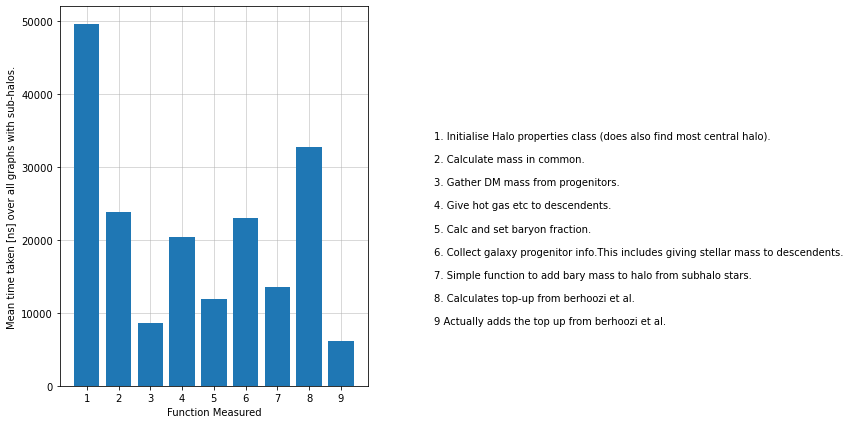

W:\FYP\Final-Year-Project-py-galaxies\PyGalaxies\Monitor.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels)


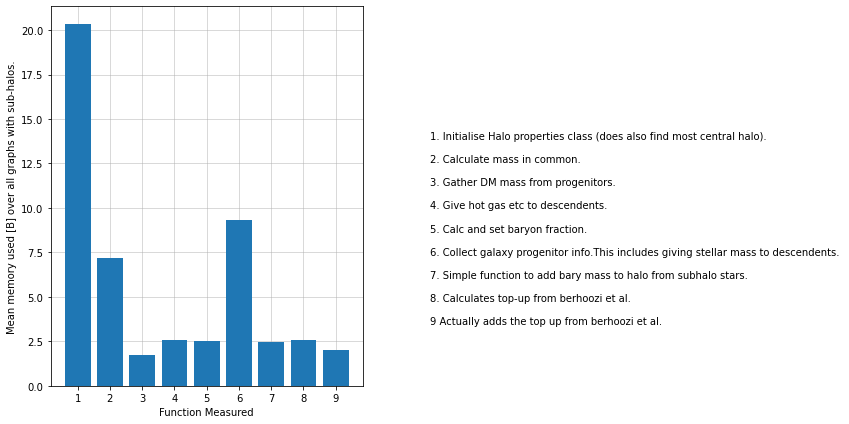

In [4]:
time_monitor.plot_timing_barchart(model_params.timing_data_save_path,
                                   model_params.input_filepath,
                                   model_params.timing_graph_save_path)

time_monitor.plot_memory_barchart(model_params.timing_data_save_path,
                                   model_params.input_filepath,
                                   model_params.timing_graph_save_path)

In [5]:
time_monitor = Monitor.Monitor(1000, 9)


In [6]:
import matplotlib.pyplot as plt


the_data = np.load('Monitoring Data/Memory Data mega_graph_mini_09-11.npy')

print(the_data.shape)

(976, 9, 3)


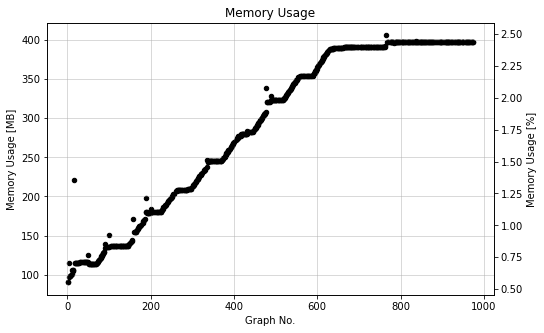

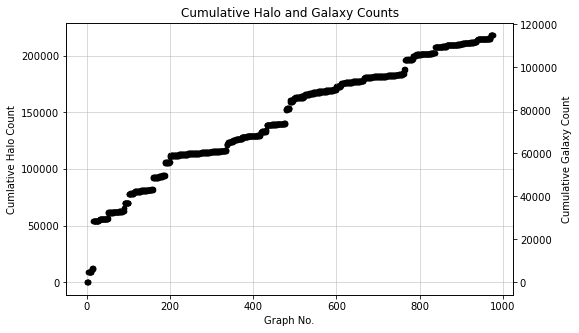

In [7]:


fig, ax1 = plt.subplots(figsize=(8,5))


ax1.set_title('Memory Usage')
ax1.scatter(np.arange(0,len(the_data[:,-1,0]),1),the_data[:,1,0]/(2**20), color='black',s = 20)
ax1.set_ylabel('Memory Usage [MB]')
ax1.set_xlabel('Graph No.')

ax2 = ax1.twinx()

ax2.scatter(np.arange(0,len(the_data[:,-1,0]),1),(the_data[:,-1,2]),color='black',s=10)
ax2.set_ylabel('Memory Usage [%]')
ax1.grid(True, alpha=0.6)
plt.savefig('Graph_outputs/Timing/Overall_Memory_Usage.jpg', dpi = 600)
plt.show()



fig,ax1 = plt.subplots(figsize=(8,5))
ax1.set_title('Cumulative Halo and Galaxy Counts')
ax1.scatter(np.arange(0,len(cum_halo_list)),cum_halo_list, color='black', s=20)
ax1.set_ylabel('Cumlative Halo Count')
ax1.grid(True,alpha=0.6)
ax1.set_xlabel('Graph No.')
ax2 = ax1.twinx()

ax2.scatter(np.arange(0,len(cum_sub_halo_list)),cum_sub_halo_list, color='black', s=20)
ax2.set_ylabel('Cumulative Galaxy Count')
plt.savefig('Graph_outputs/Timing/Overall_Halo_Count.jpg', dpi = 600)
plt.show()
